# Model Building & Evaluations
---

In [1]:
%run Module-2-helper.py
import datetime
import os
import pandas as pd
import sklearn
# Helper Function on Reading Files
def read_from_files(directory, start, end):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f>=start+'.pkl' and f<=end+'.pkl']
    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    df_final=df_final.replace([-1],0) # marking the missing values
    return df_final

# Split datasets based on three period: train period, gap period, test period
def get_train_test_set(transactions_df, train_start,train_gap=7,
                        gap_delay=7,test_gap=7,sampling_ratio=1, random_state=33):
    train_df = transactions_df[(transactions_df.Trans_DATETIME>=train_start) 
                               & (transactions_df.Trans_DATETIME<train_start+datetime.timedelta(days=train_gap))]
    test_df = []
    # Generating the valid test set
    # First,defrauded customer ID
    obs_fraud = set(train_df[train_df.Trans_FRAUD==1].CUSTOMER_ID)
    # Find the relative start day
    start_time_train = train_df.Trans_TIME_DAYS.min()
    # Looping to find the compromised card, and considering the delay period
    for day in range(test_gap):
        test_df_day = transactions_df[transactions_df.Trans_TIME_DAYS==start_time_train+train_gap+gap_delay+day]
        test_df_day_delay_period = transactions_df[transactions_df.Trans_TIME_DAYS==start_time_train+train_gap+day-1]
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.Trans_FRAUD==1].CUSTOMER_ID)
        obs_fraud = obs_fraud.union(new_defrauded_customers)
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(obs_fraud)]
        test_df.append(test_df_day)
    test_df = pd.concat(test_df)
    # This is the section because of resampling issues for imbalance classes
    # If subsample
    if sampling_ratio<1:
        train_df_frauds=train_df[train_df.Trans_FRAUD==1].sample(frac=sampling_ratio, random_state=random_state)
        train_df_genuine=train_df[train_df.Trans_FRAUD==0].sample(frac=sampling_ratio, random_state=random_state)
        train_df=pd.concat([train_df_frauds,train_df_genuine])
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    return (train_df, test_df)


In [ ]:
def grid_search(transactions_df, 
                classifier, input_features, output_feature, parameters, scoring, 
                train_start, n_folds=4,expe_type='Test',train_gap=7, gap_delay=7, 
                delta_assessment=7,performance_grid=['roc_auc'],
                metrics=['AUC ROC'],n_jobs=-1):
    def split(transactions_df, train_start, n_folds=4, train_gap=7, gap_delay=7, delta_assessment=7):
        grid_indices=[]
        # Start an iteration to go throught all the folds
        for fold in range(n_folds):
            train_start = train_start-datetime.timedelta(days=fold*delta_assessment)
            # Updating the train and test data sets
            (train_df, test_df)=get_train_test_set(transactions_df, train_start=train_start,
                                                train_gap=train_gap,gap_delay=gap_delay,test_gap=delta_assessment)
            indices_train=list(train_df.index)
            indices_test=list(test_df.index)
            grid_indices.append((indices_train,indices_test))
        return grid_indices
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    grid_indices=split(transactions_df,train_start=train_start, n_folds=n_folds, train_gap=train_gap, 
                        gap_delay=gap_delay, delta_assessment=delta_assessment)
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=grid_indices, refit=False, n_jobs=n_jobs)
    X, y = transactions_df[input_features], transactions_df[output_feature]
    grid_search.fit(X, y)
    performances_df=pd.DataFrame()
    for i in range(len(performance_grid)):
        performances_df[metrics[i]+' '+expe_type]=grid_search.cv_results_['avg_test_'+performance_grid[i]]
        performances_df[metrics[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_grid[i]]
    performances_df['Parameters']=grid_search.cv_results_['params']
    performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']
    return performances_df

# Decision Tree 
---

In [90]:
# Load data from the 2018-06-11 to the 2018-09-14
INPUT = './simulated-data-transformed' 
BD = "2022-01-15"
ED = "2022-04-20"
print("Load  files")
transactions_df = read_from_files(INPUT, BD, ED)
output_feature = "Trans_FRAUD"
input_features = ['Trans_AMOUNT','Trans_DURING_WEEKEND', 'Trans_DURING_NIGHT', 'CUSTOMER_ID_NB_Trans_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'STORE_ID_NB_Trans_1DAY_WINDOW',
       'STORE_ID_RISK_1DAY_WINDOW', 'STORE_ID_NB_Trans_7DAY_WINDOW',
       'STORE_ID_RISK_7DAY_WINDOW', 'STORE_ID_NB_Trans_30DAY_WINDOW',
       'STORE_ID_RISK_30DAY_WINDOW']

Load  files


In [91]:
# Number of folds for validation
n_folds = 4
# Set the starting day
train_start_date = datetime.datetime.strptime("2022-02-28", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7
valid_train_start_date = train_start_date + datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = train_start_date + datetime.timedelta(days=(n_folds-1)*delta_test)


In [92]:
# Keeping the needed columns and formatting the metrics
scorer = transactions_df[['CUSTOMER_ID', 'Trans_FRAUD','Trans_TIME_DAYS']]
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=scorer)
# @reference metric using in Alon's metrics
performance_grid = ['roc_auc', 'average_precision', 'card_precision@100'] 
metrics = ['AUC ROC', 'Average precision', 'Card Precision@100']
scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100
           }


In [93]:

# Model
classifier = sklearn.tree.DecisionTreeClassifier()
# Tuning Hyper-parameter
parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50,75], 'clf__random_state':[0]}
# recording the running time
start_time = time.time()
# Fit models and assess performances for all parameters
def all_performance(transactions_df, classifier, input_features, output_feature,
                            parameters, scoring, 
                            start_date_training_for_valid, start_date_training_for_test,
                            n_folds=4,train_gap=7, gap_delay=7, delta_assessment=7,
                            performance_grid=['roc_auc'],
                            metrics=['AUC ROC'],n_jobs=-1):
    # Valid Sets
    performances_df_validation=grid_search(transactions_df, classifier, 
                                        input_features, output_feature,parameters, scoring, 
                                        train_start=start_date_training_for_valid, n_folds=n_folds,expe_type='Validation',
                                        train_gap=train_gap, gap_delay=gap_delay, delta_assessment=delta_assessment,performance_grid=performance_grid,
                                        metrics=metrics,n_jobs=n_jobs)
    # test set
    performances_df_test=grid_search(transactions_df, classifier,input_features, output_feature,
                            parameters, scoring,train_start=start_date_training_for_test,
                            n_folds=n_folds,expe_type='Test',train_gap=train_gap, gap_delay=gap_delay, delta_assessment=delta_assessment,performance_grid=performance_grid,
                            metrics=metrics,n_jobs=n_jobs)
    # Output
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)
    return performances_df
    
performances_df=all_performance(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        valid_train_start_date,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_grid=performance_grid,
                                        metrics=metrics,
                                        n_jobs=1)
# The best parameters
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]
# For model Comparison
decision_tree=performances_df

In [ ]:
decision_tree

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.760550,0.007122,0.419822,0.015840,0.381429,0.024702,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.441041,0.779055,0.006532,0.464257,0.007255,0.402857,0.018406,2
1,0.767051,0.009392,0.489381,0.011747,0.388214,0.029904,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.525254,0.784937,0.006387,0.530790,0.013025,0.412143,0.019312,3
2,0.773661,0.007533,0.516642,0.016120,0.399286,0.025405,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.606777,0.785644,0.007255,0.557105,0.019200,0.409286,0.023765,4
3,0.774974,0.008803,0.523959,0.016756,0.400000,0.022338,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.693230,0.785504,0.005777,0.553309,0.013548,0.405714,0.017113,5
4,0.767819,0.011742,0.522342,0.015627,0.401071,0.021294,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.785157,0.783250,0.003844,0.519537,0.051682,0.404643,0.015131,6
5,0.754036,0.005699,0.501578,0.020609,0.392500,0.025483,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.868040,0.780377,0.006730,0.509614,0.045779,0.399643,0.015266,7
6,0.746190,0.003101,0.484691,0.015561,0.384643,0.029231,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.952483,0.766523,0.018691,0.505938,0.050618,0.397500,0.015984,8
7,0.739451,0.006154,0.481737,0.020485,0.383929,0.028165,"{'clf__max_depth': 9, 'clf__random_state': 0}",1.031853,0.773066,0.028506,0.486591,0.060649,0.395714,0.017409,9
8,0.734358,0.014654,0.479437,0.017484,0.383214,0.027131,"{'clf__max_depth': 10, 'clf__random_state': 0}",1.113366,0.769319,0.030731,0.498958,0.039274,0.395000,0.016918,10
9,0.757598,0.016951,0.390405,0.027716,0.382500,0.026848,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.797515,0.768372,0.016163,0.392702,0.037631,0.396786,0.018962,20


In [ ]:
summary_performances_dt=get_summary_performances(decision_tree parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,4,4,3
Validation performance,0.786+/-0.01,0.557+/-0.02,0.412+/-0.02
Test performance,0.774+/-0.01,0.517+/-0.02,0.388+/-0.03
Optimal parameters,5,5,6
Optimal test performance,0.775+/-0.01,0.524+/-0.02,0.401+/-0.02


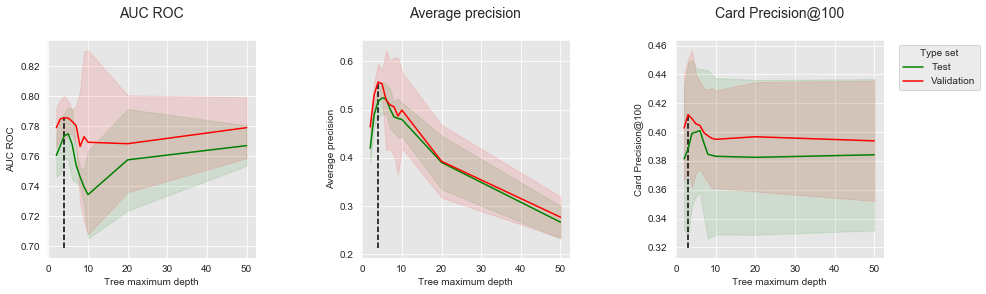

In [ ]:
get_performances_plots(decision_tree 
                       metrics=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

# Logistic Regression 
---

In [ ]:
classifier = sklearn.linear_model.LogisticRegression()
parameters = {'clf__C':[0.1,1,10,20, 30, 49, 50,100], 'clf__random_state':[0]}
start_time=time.time()
performances_df=all_performance(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        valid_train_start_date,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_grid=performance_grid,
                                        metrics=metrics,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]
# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [ ]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.789638,0.006668,0.425644,0.012453,0.384286,0.021500,"{'clf__C': 0.1, 'clf__random_state': 0}",0.731192,0.812262,0.008426,0.445994,0.021123,0.397500,0.018333,0.1
1,0.790546,0.006407,0.429357,0.011668,0.382500,0.021955,"{'clf__C': 1, 'clf__random_state': 0}",0.823256,0.813071,0.008763,0.449192,0.021692,0.394643,0.018165,1.0
2,0.790646,0.006389,0.429687,0.011492,0.381429,0.020874,"{'clf__C': 10, 'clf__random_state': 0}",0.768235,0.813170,0.008812,0.449456,0.021711,0.394286,0.018708,10.0
3,0.790651,0.006384,0.429713,0.011486,0.381429,0.020874,"{'clf__C': 20, 'clf__random_state': 0}",0.787027,0.813176,0.008814,0.449470,0.021714,0.394286,0.018708,20.0
4,0.790655,0.006385,0.429726,0.011471,0.381429,0.020874,"{'clf__C': 30, 'clf__random_state': 0}",0.756715,0.813180,0.008817,0.449462,0.021724,0.394286,0.018708,30.0
5,0.790657,0.006385,0.429730,0.011466,0.381429,0.020874,"{'clf__C': 49, 'clf__random_state': 0}",0.750287,0.813180,0.008819,0.449468,0.021727,0.394286,0.018708,49.0
6,0.790656,0.006385,0.429733,0.011464,0.381429,0.020874,"{'clf__C': 50, 'clf__random_state': 0}",0.823935,0.813180,0.008816,0.449476,0.021728,0.394286,0.018708,50.0
7,0.790657,0.006385,0.429737,0.011456,0.381429,0.020874,"{'clf__C': 100, 'clf__random_state': 0}",0.765599,0.813180,0.008816,0.449473,0.021718,0.394286,0.018708,100.0


In [ ]:
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,49.0,50.0,0.1
Validation performance,0.813+/-0.01,0.449+/-0.02,0.397+/-0.02
Test performance,0.791+/-0.01,0.43+/-0.01,0.384+/-0.02
Optimal parameters,49.0,100.0,0.1
Optimal test performance,0.791+/-0.01,0.43+/-0.01,0.384+/-0.02


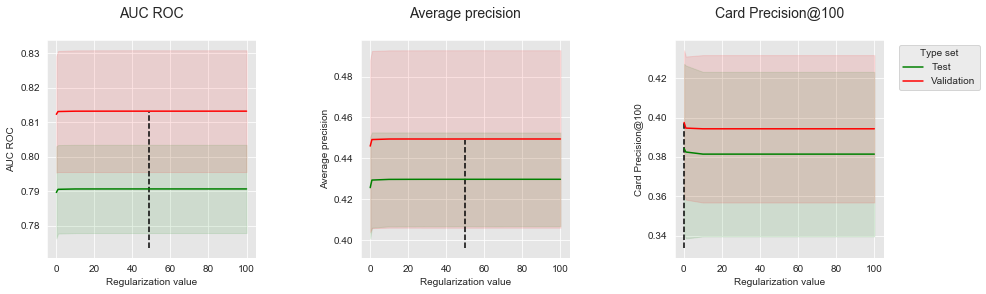

In [ ]:
get_performances_plots(performances_df_lr, 
                       metrics=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_performances_lr)

# Random Forest
---

In [ ]:
classifier = sklearn.ensemble.RandomForestClassifier()
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}
start_time=time.time()
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        valid_train_start_date,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_grid=performance_grid,
                                        metrics=metrics,
                                        n_jobs=1)
execution_time_rf = time.time()-start_time
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]
performances_df_rf = performances_df


In [ ]:
performances_df_rf

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.772452,0.017847,0.555597,0.013983,0.402500,0.022574,"{'clf__max_depth': 5, 'clf__n_estimators': 25,...",2.017082,0.792750,0.028892,0.582403,0.009868,0.415357,0.018881,25/5
1,0.776275,0.024793,0.556679,0.013911,0.402857,0.022745,"{'clf__max_depth': 5, 'clf__n_estimators': 50,...",3.785037,0.793485,0.027052,0.583729,0.009192,0.415000,0.017914,50/5
2,0.785674,0.023466,0.557906,0.013764,0.402857,0.022745,"{'clf__max_depth': 5, 'clf__n_estimators': 100...",7.263047,0.794038,0.029353,0.584885,0.010930,0.414643,0.020111,100/5
3,0.791135,0.011350,0.570664,0.016922,0.410357,0.021485,"{'clf__max_depth': 10, 'clf__n_estimators': 25...",3.504190,0.804133,0.029485,0.592485,0.009549,0.418214,0.019043,25/10
4,0.797785,0.010920,0.575185,0.013868,0.412143,0.021630,"{'clf__max_depth': 10, 'clf__n_estimators': 50...",6.610437,0.807137,0.029997,0.594886,0.009717,0.418571,0.018323,50/10
5,0.800680,0.009073,0.576657,0.012770,0.412143,0.021888,"{'clf__max_depth': 10, 'clf__n_estimators': 10...",12.671120,0.808355,0.031215,0.595213,0.009677,0.418571,0.017409,100/10
6,0.797710,0.011255,0.581597,0.012503,0.412500,0.021053,"{'clf__max_depth': 20, 'clf__n_estimators': 25...",5.369430,0.807870,0.017382,0.598968,0.011091,0.416429,0.016948,25/20
7,0.803752,0.009008,0.589209,0.012408,0.415000,0.020316,"{'clf__max_depth': 20, 'clf__n_estimators': 50...",10.389270,0.808954,0.016437,0.602102,0.011363,0.418929,0.018472,50/20
8,0.808201,0.006729,0.591054,0.012006,0.416429,0.020665,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",20.595969,0.809793,0.015594,0.603369,0.011648,0.417500,0.020111,100/20
9,0.802972,0.007991,0.573684,0.013166,0.410714,0.023485,"{'clf__max_depth': 50, 'clf__n_estimators': 25...",5.759646,0.806076,0.005296,0.589051,0.013476,0.416071,0.017565,25/50


In [ ]:
summary_performances_rf = get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/50,100/20,100/50
Validation performance,0.81+/-0.01,0.603+/-0.01,0.419+/-0.02
Test performance,0.808+/-0.01,0.591+/-0.01,0.417+/-0.02
Optimal parameters,100/20,100/20,100/50
Optimal test performance,0.808+/-0.01,0.591+/-0.01,0.417+/-0.02


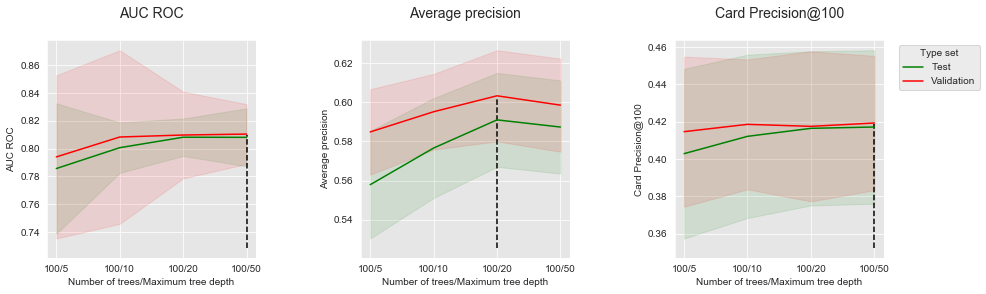

In [ ]:
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]
summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")
get_performances_plots(performances_df_rf_fixed_number_of_trees, 
                       metrics=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

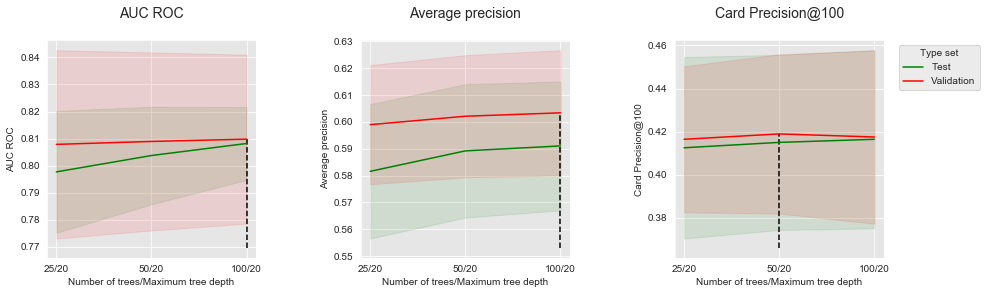

In [ ]:
performances_df_rf_fixed_max_tree_depth=performances_df_rf[performances_df_rf["Parameters summary"].str.endswith("20")]
summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_rf_fixed_max_tree_depth, parameter_column_name="Parameters summary")
get_performances_plots(performances_df_rf_fixed_max_tree_depth, 
                       metrics=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

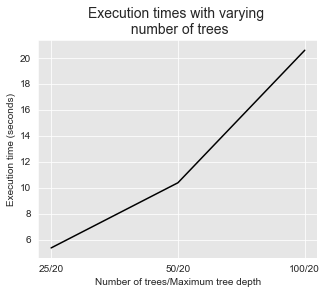

In [ ]:
get_execution_times_plot(performances_df_rf_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Maximum tree depth")

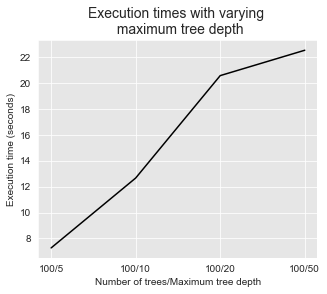

In [ ]:
get_execution_times_plot(performances_df_rf_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Maximum tree depth")

In [ ]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_rf,2))+"s")

Total execution time for the model selection procedure: 952.44s


# XGBoosting
---

In [ ]:
classifier = xgboost.XGBClassifier()
parameters = {'clf__max_depth':[3,6,9], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.1, 0.3],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}
start_time=time.time()
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        valid_train_start_date,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_grid=performance_grid,
                                        metrics=metrics,
                                        n_jobs=1)
execution_time_boosting = time.time()-start_time
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]
performances_df_xgboost=performances_df

In [ ]:
performances_df_xgboost

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.780733,0.008644,0.550042,0.014985,0.407500,0.022117,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",1.777726,0.793296,0.014081,0.573569,0.013156,0.415000,0.017800,25/0.1/3
1,0.781681,0.014912,0.556897,0.015484,0.408214,0.019984,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",3.249065,0.810389,0.021578,0.588974,0.012827,0.417857,0.019418,50/0.1/3
2,0.807690,0.009972,0.581379,0.007914,0.413929,0.020858,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",6.128389,0.807998,0.030156,0.600353,0.012176,0.418571,0.016225,100/0.1/3
3,0.776754,0.011971,0.547488,0.009807,0.405000,0.024918,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",3.018084,0.798781,0.014058,0.579631,0.010848,0.412500,0.018277,25/0.1/6
4,0.793827,0.011040,0.558381,0.012492,0.406429,0.022599,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",5.926466,0.807473,0.033139,0.591787,0.013410,0.414643,0.020238,50/0.1/6
5,0.810751,0.006210,0.579838,0.008439,0.407857,0.025102,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",12.213352,0.805647,0.028818,0.596372,0.011663,0.414643,0.019597,100/0.1/6
6,0.775333,0.011171,0.545918,0.011432,0.403571,0.023958,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",3.534690,0.799836,0.013074,0.578239,0.010852,0.412143,0.020442,25/0.1/9
7,0.800535,0.010614,0.557434,0.010736,0.404643,0.023373,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",8.214830,0.802322,0.036562,0.592945,0.013832,0.415000,0.018749,50/0.1/9
8,0.808425,0.004153,0.577671,0.006176,0.404643,0.025038,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",18.056330,0.804879,0.028653,0.592626,0.013367,0.414286,0.017525,100/0.1/9
9,0.788022,0.010797,0.571173,0.009219,0.410714,0.022531,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",1.799833,0.802558,0.030000,0.597302,0.012223,0.418214,0.016824,25/0.3/3


In [ ]:
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.3/9,100/0.1/3,100/0.1/3
Validation performance,0.811+/-0.02,0.6+/-0.01,0.419+/-0.02
Test performance,0.806+/-0.0,0.581+/-0.01,0.414+/-0.02
Optimal parameters,100/0.3/3,100/0.3/3,50/0.3/3
Optimal test performance,0.813+/-0.01,0.594+/-0.01,0.414+/-0.02


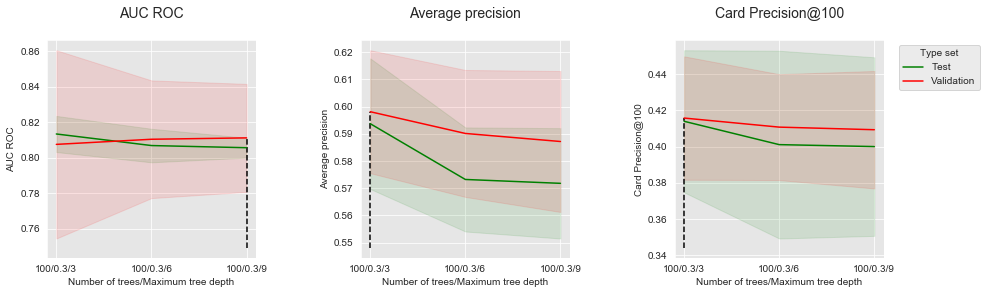

In [ ]:
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.3")]
summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")
get_performances_plots(performances_df_xgboost_fixed_number_of_trees, 
                       metrics=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

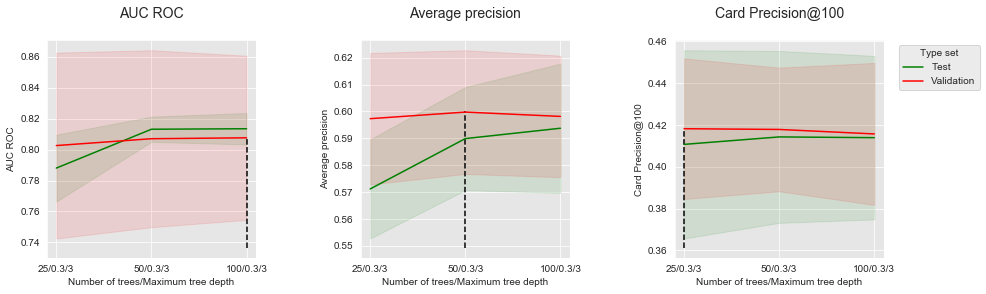

In [ ]:
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.3/3")]
summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")
get_performances_plots(performances_df_xgboost_fixed_max_tree_depth, 
                       metrics=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

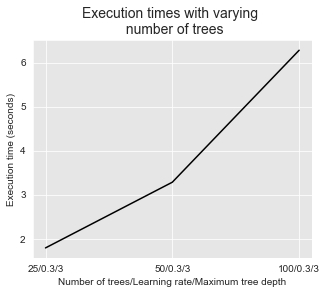

In [ ]:
get_execution_times_plot(performances_df_xgboost_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

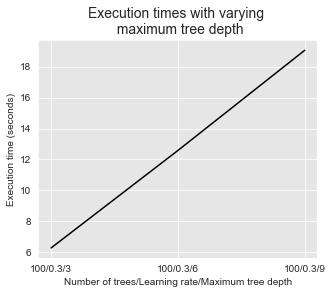

In [ ]:
get_execution_times_plot(performances_df_xgboost_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

In [ ]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_boosting,2))+"s")

Total execution time for the model selection procedure: 1065.48s


# Comparison Between Models
---

In [ ]:
performances_df_dictionary={
    "Decision Tree": decision_tree,
    "Logistic Regression": performances_df_lr,
    "Random Forest": performances_df_rf,
    "XGBoost": performances_df_xgboost
}

In [ ]:
model_selection_performances(performances_df_dictionary,
                             performance_metric='AUC ROC')

({'Default parameters': [0.767, 0.791, 0.808, 0.807],
  'Best validation parameters': [0.774, 0.791, 0.808, 0.806],
  'Optimal parameters': [0.775, 0.791, 0.808, 0.813]},
 {'Default parameters': [0.007, 0.006, 0.01, 0.005],
  'Best validation parameters': [0.01, 0.01, 0.01, 0.0],
  'Optimal parameters': [0.01, 0.01, 0.01, 0.01]})

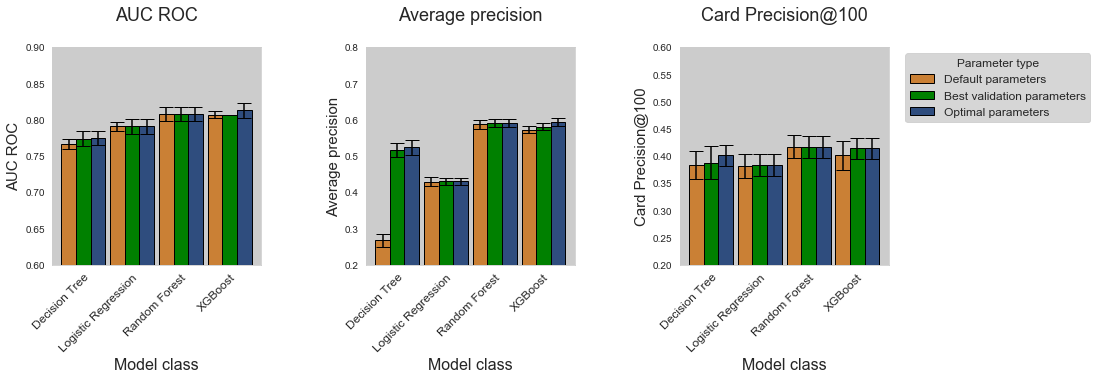

In [ ]:
get_model_selection_performances_plots(performances_df_dictionary, 
                                        metrics=['AUC ROC', 'Average precision', 'Card Precision@100'])
    

In [ ]:
execution_times=[execution_time_dt,execution_time_lr,
                 execution_time_rf,execution_time_boosting]


In [ ]:
%%capture
fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))
model_classes=['Decision Tree','Logistic Regression','Random Forest','XGBoost'] 
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(model_classes))
# Create execution times bars
ax.bar(r1, execution_times[0:4], 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)
ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)

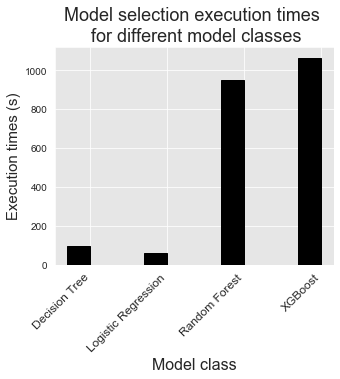

In [ ]:
fig_model_selection_execution_times_for_each_model_class